In [1]:
"""
author: EdgardoCS @FSU Jena
date: 16.04.2025
"""

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pd.options.mode.chained_assignment = None

In [2]:
input_data = "output/data_sorted.xlsx"
columns = ['Id', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])

# Conditions:
# front + Self + Female
# front + Self + Male
# front + Other + Female
# front + Other + Male
#
# back + Self + Female
# back + Self + Male
# back + Other + Female
# back + Other + Male

In [3]:
# Factor	Levels	            Type
# Gender	Male, Female	    Between-subjects
# Type	    Self, Other	        Within-subjects (each participant rated both)
# Location	Front, Back	        Within-subjects
# Segment	9 regions           Within-subjects

# Dependent variable
#   Points in image (smell rating)
# Independent variables / Fixed effects
#   Gender
#   Type
#   Location
#   Segment
# Random effect
#   Subject

In [4]:
data['Gender'] = data['Gender'].astype('category')
data['Segment'] = data['Segment'].astype('category')
data['Location'] = data['Location'].astype('category')
data['Type'] = data['Type'].astype('category')
# data['id'] = data['id'].astype('category')  # Random effect

In [5]:
female = data[data['Gender'] == 'Female'].copy()
male = data[data['Gender'] == 'Male'].copy()
col_order = ["Armpits", "Chest", "Feet", "Hair", "Hands", "Legs", "Mouth", "Neck", "Pelvis"]

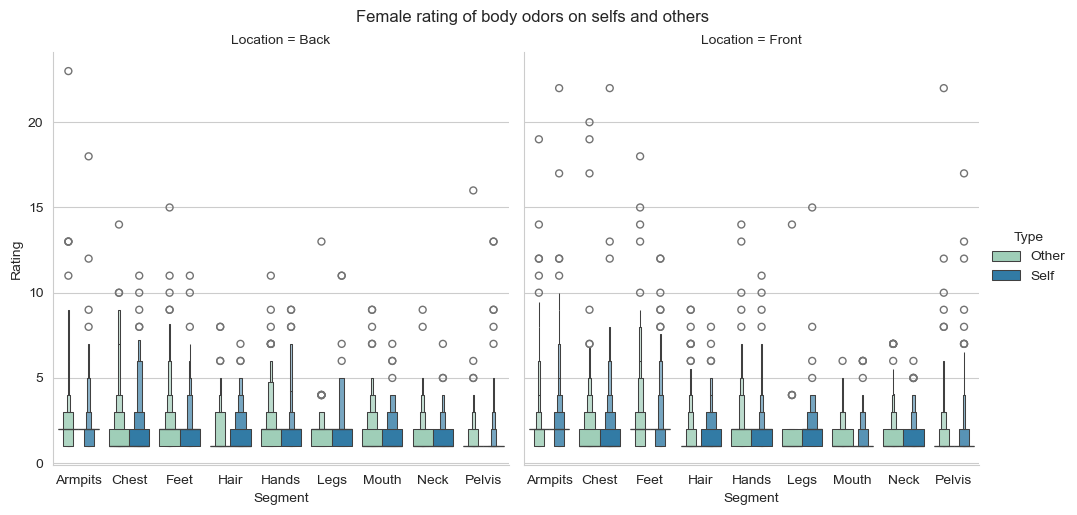

In [6]:
sns.catplot(
    data=female,
    kind='boxen',
    x='Segment',
    y='Rating',
    hue='Type',
    palette='YlGnBu',
    col='Location',
    col_wrap=2,
    order=col_order

    # showfliers=False
)
# plt.tight_layout()
plt.suptitle('Female rating of body odors on selfs and others', y=1.02)
plt.savefig('output/stats/female.boxen.png', bbox_inches='tight', dpi=300)

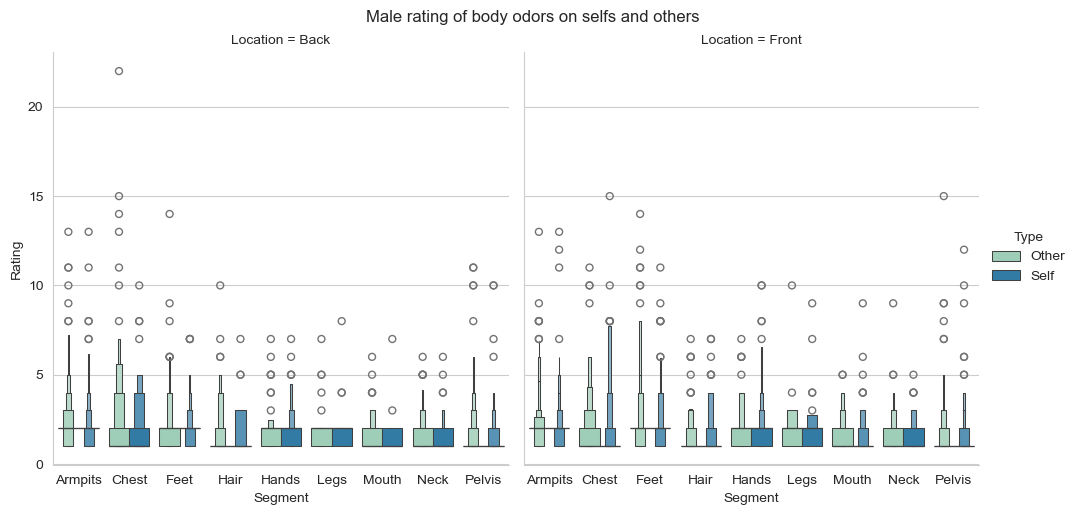

In [7]:
sns.catplot(
    data=male,
    kind='boxen',
    x='Segment',
    y='Rating',
    hue='Type',
    palette='YlGnBu',
    col='Location',
    col_wrap=2,
    order=col_order
    # showfliers=False
)
# plt.tight_layout()
plt.suptitle('Male rating of body odors on selfs and others', y=1.02)
plt.savefig('output/stats/male.boxen.png', bbox_inches='tight', dpi=300)

In [8]:
# Mixed model effects for the whole sample
model = smf.mixedlm(
    "Rating ~ Segment * Location * Type * Gender",
    data,
    groups=data["Id"]
)
result = model.fit()
print(result.summary())

# Reference: Female, Others, armpit
# Intercept 2,004, p = 0,000 (***)

# Location (front) 0,032, p 0,466 (ns)
# Type (Self) -0,004, p = 0,941 (ns)
# Gender (Male) 0,082, p = 0,207 (ns)
# β, p
# Segment[T.chest] -0.266, p = 0.000 (***)
# Segment[T.feet] -0.034, p = 0.518 (ns)
# Segment[T.hair] -0.670, p = 0.000 (***)
# Segment[T.hand] -0.298, p = 0.000 (***)
# Segment[T.legs] -0.367, p = 0.000 (***)
# Segment[T.mouth] -0.583, p = 0.000 (***)
# Segment[T.neck] -0.637, p = 0.000 (***)
# Segment[T.pelvis] -0.802, p = 0.000 (***)

# Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower with the exception of the feet.
# chest is rated higher in the back (β = -0.207, p = 0.016), as well as legs (β = -0.335, p = 0.017)
# feet are rated higher in the front (β = 0.178, p = 0.007), as well as neck (β = 0.156, p = 0.027)
# No significant three- or four-way interactions involving Type (p = 0,941) or Gender (p = 0,207) were observed.


                                   Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 Rating     
No. Observations:                   26915                   Method:                             REML       
No. Groups:                         2409                    Scale:                              0.9005     
Min. group size:                    1                       Log-Likelihood:                     -39005.2520
Max. group size:                    36                      Converged:                          Yes        
Mean group size:                    11.2                                                                   
-----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------

In [9]:
# 1. Is there any difference between Female and Male when smelling Others?
target = (data[
              (data['Type'] == 'Other') &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
# same model, only for type others
model = smf.mixedlm(
    "Rating ~ Segment * Location * Gender",
    target,
    groups=target["Id"]
)
result1 = model.fit()

print(result1.summary())

# Armpit was rated higher in comparison to other segments, significantly for exception of feet (β = -0,038, p = 0,409)
# Gender has no significant effect when smelling others (β = 0,070, p = 0,300), niether location (β = 0,019, p = 0,678)
# Again, there is an observed significant difference for segments Chest, Feet, Legs and Neck


                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Rating     
No. Observations:              14714               Method:                         REML       
No. Groups:                    2396                Scale:                          0.9401     
Min. group size:               1                   Log-Likelihood:                 -22081.4538
Max. group size:               18                  Converged:                      Yes        
Mean group size:               6.1                                                            
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           2.021    0.041  49.495 0.00

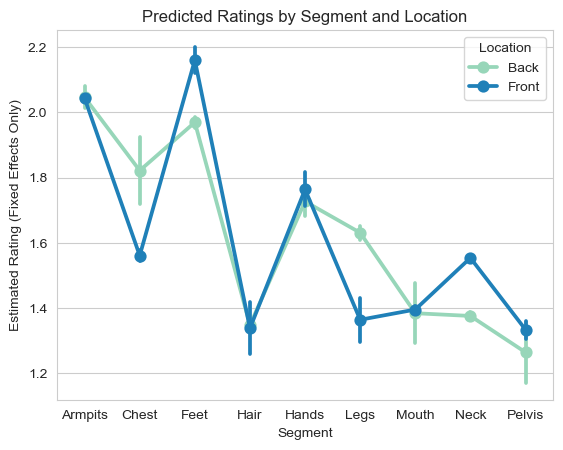

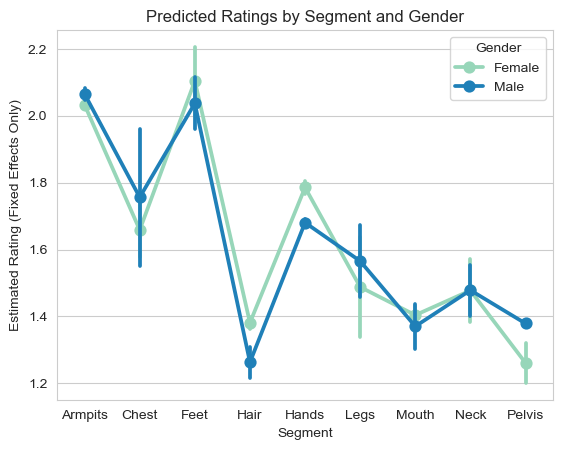

In [10]:
predict_df = target.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = result1.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Location",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Location")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Gender",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Gender")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
# 2. Is there any difference between Female and Male when smelling Themselves?
target = (data[
              (data['Type'] == 'Self') &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
# same model, only for type others
model = smf.mixedlm(
    "Rating ~ Segment * Location * Gender",
    target,
    groups=target["Id"]
)
result2 = model.fit()
print(result2.summary())

# Armpit was rated higher in comparison to other segments
# Gender has no significant effect when smelling others (β = 0,070, p = 0,300),
# There is an overall significant effect of location (β = 0.097, p = 0.045), where front is rated higher than back. However, individual segments dont show such difference


                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Rating     
No. Observations:              12201               Method:                         REML       
No. Groups:                    2369                Scale:                          0.8013     
Min. group size:               1                   Log-Likelihood:                 -17460.2851
Max. group size:               18                  Converged:                      Yes        
Mean group size:               5.2                                                            
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           2.019    0.041  49.264 0.00

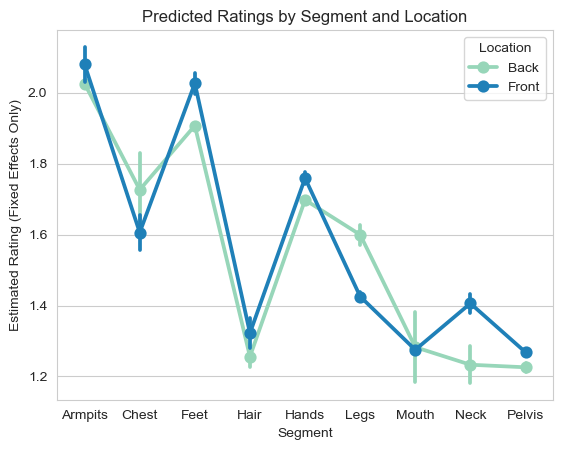

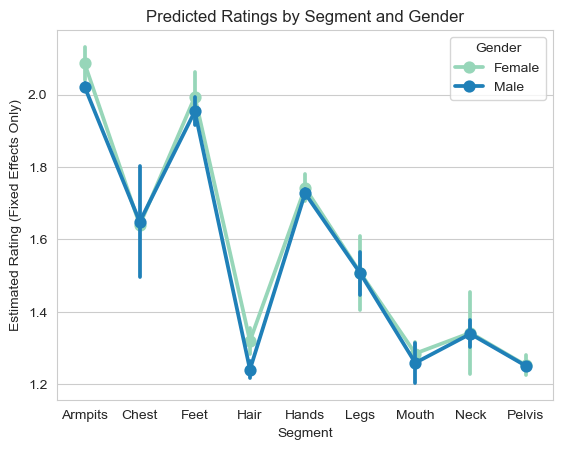

In [12]:
predict_df = target.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = result2.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Location",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Location")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-self-location.png', bbox_inches='tight', dpi=300)
plt.show()

sns.pointplot(
    data=predict_df,
    x="Segment",
    hue="Gender",
    y="Predicted",
    errorbar="sd",
    palette='YlGnBu'
)
plt.title("Predicted Ratings by Segment and Gender")
plt.ylabel("Estimated Rating (Fixed Effects Only)")
plt.savefig('output/stats/pointplot-self-gender.png', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "Rating ~ Segment * Location",
    data=target,
    groups=target["Id"],
    re_formula="~1"
)
result = model.fit()
print(result.summary())

target["Predicted"] = result.predict()

segment_means = (
    target.groupby("Segment")["Predicted"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

segment_means["se"] = segment_means["std"] / np.sqrt(segment_means["count"])
segment_means["ci95"] = 1.96 * segment_means["se"]

import itertools
from scipy.stats import ttest_rel

segments = target["Segment"].unique()
comparisons = []

for s1, s2 in itertools.combinations(segments, 2):
    df1 = target[target["Segment"] == s1].sort_values("Id")
    df2 = target[target["Segment"] == s2].sort_values("Id")

    merged = df1.merge(df2, on="Id", suffixes=(f"_{s1}", f"_{s2}"))

    t, p = ttest_rel(merged[f"Predicted_{s1}"], merged[f"Predicted_{s2}"])
    comparisons.append({
        "Segment 1": s1,
        "Segment 2": s2,
        "t": t,
        "p": p
    })

posthoc_df = pd.DataFrame(comparisons)
print(posthoc_df.sort_values("p"))

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        Rating     
No. Observations:         12201          Method:                    REML       
No. Groups:               2369           Scale:                     0.8012     
Min. group size:          1              Log-Likelihood:            -17441.1684
Max. group size:          18             Converged:                 Yes        
Mean group size:          5.2                                                  
-------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                            2.026    0.032  62.353 0.000  1.962  2.089
Segment[T.Chest]                    -0.299    0.068  -4.387 0.000 -0.432 -0.165
Segment[T.Feet]                     -0.118    0.043  -2.740 0

C:\Users\silva\AppData\Local\Temp\ipykernel_15616\1590573831.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target.groupby("Segment")["Predicted"]


   Segment 1 Segment 2            t              p
0    Armpits     Chest   210.589167   0.000000e+00
33     Hands      Neck   117.591243   0.000000e+00
31      Feet      Neck   186.617064   0.000000e+00
30      Feet     Hands   149.817149   0.000000e+00
27    Pelvis     Hands  -534.087291   0.000000e+00
26    Pelvis      Feet  -609.084993   0.000000e+00
23     Mouth     Hands  -378.581240   0.000000e+00
22     Mouth      Feet  -349.350745   0.000000e+00
18      Hair     Hands  -244.898120   0.000000e+00
11     Chest      Feet  -105.151588   0.000000e+00
17      Hair      Feet  -303.290308   0.000000e+00
6    Armpits      Neck   291.781321   0.000000e+00
1    Armpits      Hair   611.052328   0.000000e+00
2    Armpits     Mouth   997.339660   0.000000e+00
3    Armpits    Pelvis  1470.338705   0.000000e+00
4    Armpits      Feet    76.767181   0.000000e+00
5    Armpits     Hands   376.670483   0.000000e+00
10     Chest    Pelvis   176.287855   0.000000e+00
9      Chest     Mouth   117.31

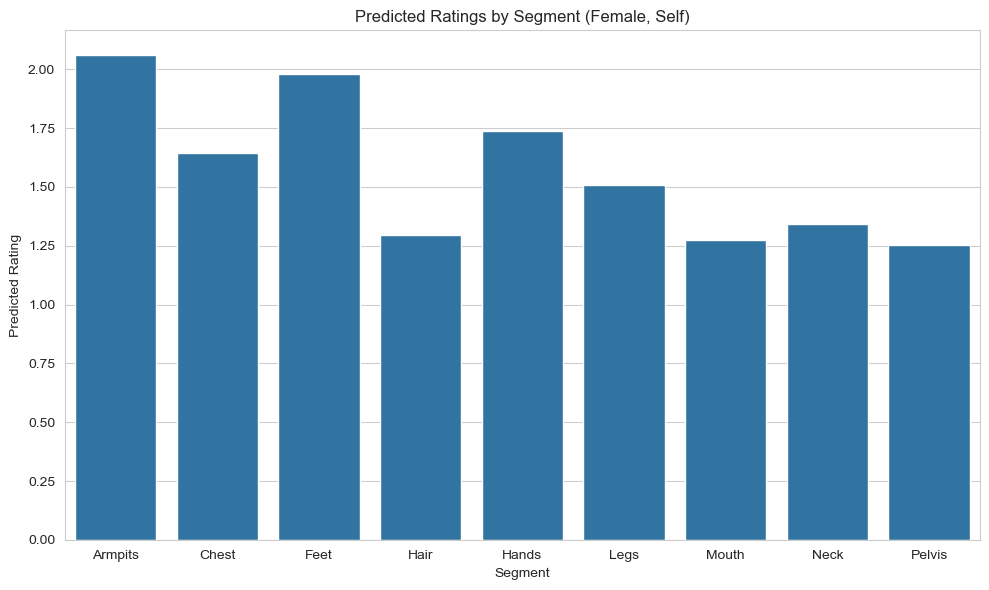

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=segment_means,
    x="Segment", y="mean",
    capsize=0.2
)
plt.ylabel("Predicted Rating")
plt.title("Predicted Ratings by Segment (Female, Self)")
plt.tight_layout()
plt.show()

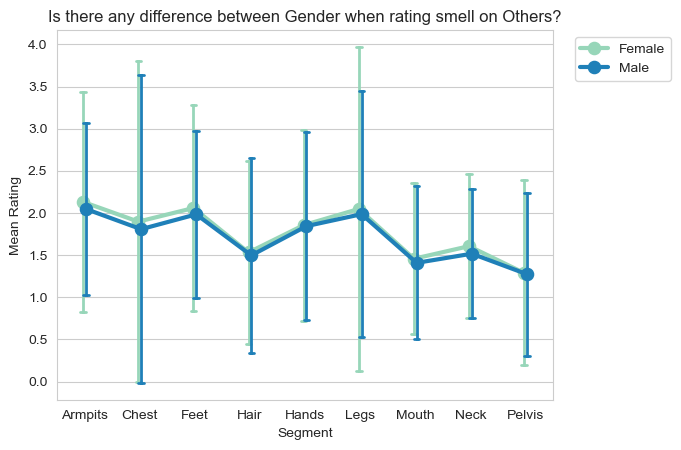

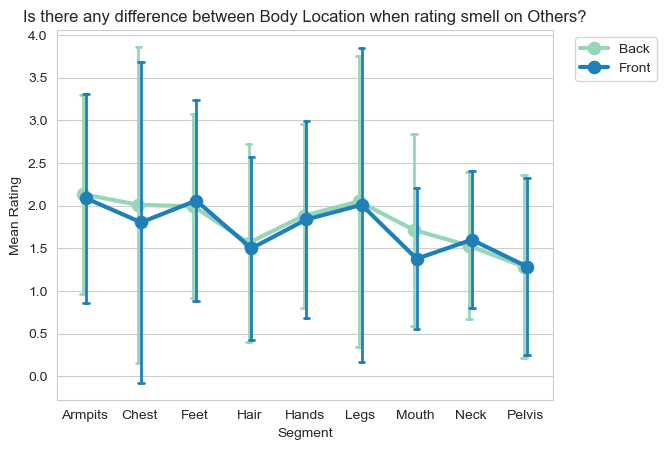

In [16]:
# Plot interaction between Segment and Gender
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Gender',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Gender when rating smell on Others?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
plt.show()

# Plot interaction between Segment and Location
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Location',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Body Location when rating smell on Others?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
# # Create a grid of all combinations
# combinations = pd.DataFrame([
#     (seg, gen, loc)
#     for seg in target['Segment'].unique()
#     for gen in target['Gender'].unique()
#     for loc in target['Location'].unique()
# ], columns=['Segment', 'Gender', 'Location'])
#
# # Predict marginal means
# combinations['Predicted'] = three_model.predict(combinations)
#
# # Plot 3-way interaction
# sns.catplot(
#     data=combinations,
#     x='Segment',
#     y='Predicted',
#     hue='Gender',
#     col='Location',
#     kind='point',
#     palette='YlGnBu',
#     errorbar=None
# )
# plt.subplots_adjust(top=0.8)
# plt.suptitle('Estimated Marginal Means: Segment x Gender x Location')
# plt.show()

In [17]:
# 2. Is there any difference between Female and Male when smelling themselves?
target = (data[
              (data['Type'] == 'Self') &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
three_model = ols("""Rating ~ C(Segment) + C(Gender) + C(Location) +
               C(Segment):C(Gender) + C(Segment):C(Location) + C(Gender):C(Location) +
               C(Segment):C(Gender):C(Location)""", data=target).fit()
res2 = anova_lm(three_model, typ=2)
#
# # C(Segment) -> p= 0,000
# # C(Gender) -> p= 0,009
# # C(Location) -> p= 0,152
# # C(Segment):C(Gender) -> p= 0,977
# # C(Segment):C(Location) -> p= 0,022
# # C(Gender):C(Location) -> p= 0,668
# # C(Segment):C(Gender):C(Location) -> p= 0,816
#
# # Answer, there is a main effect of Gender, and there is significant difference
# # between Segment and Location when participants smell themselves

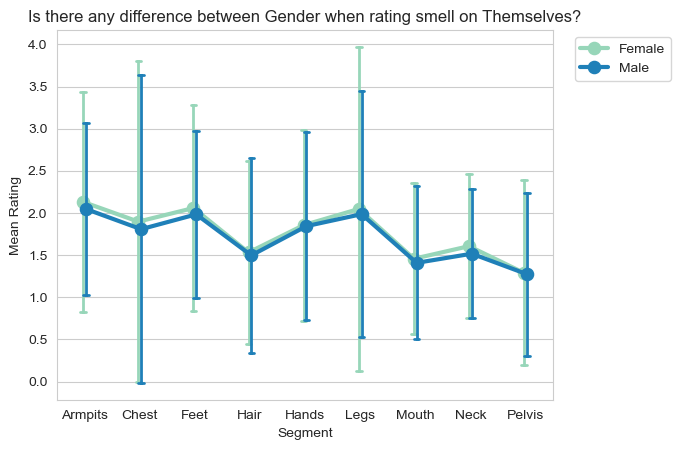

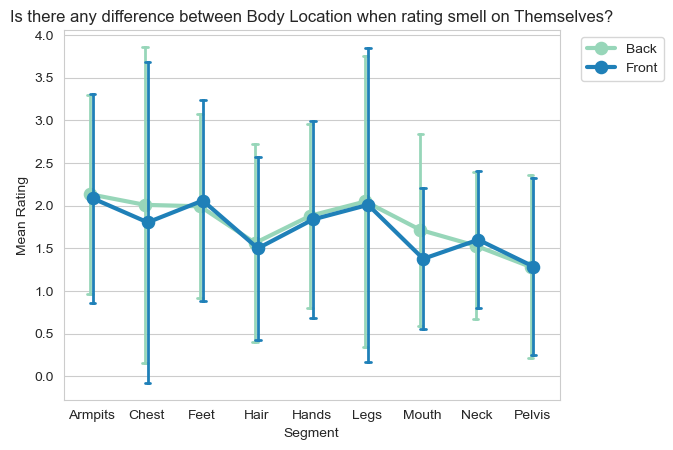

In [18]:
# Plot interaction between Segment and Gender
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Gender',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Gender when rating smell on Themselves?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-self-gender.png', bbox_inches='tight', dpi=300)
plt.show()
# Plot interaction between Segment and Location
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Location',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Body Location when rating smell on Themselves?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-self-location.png', bbox_inches='tight', dpi=300)
plt.show()

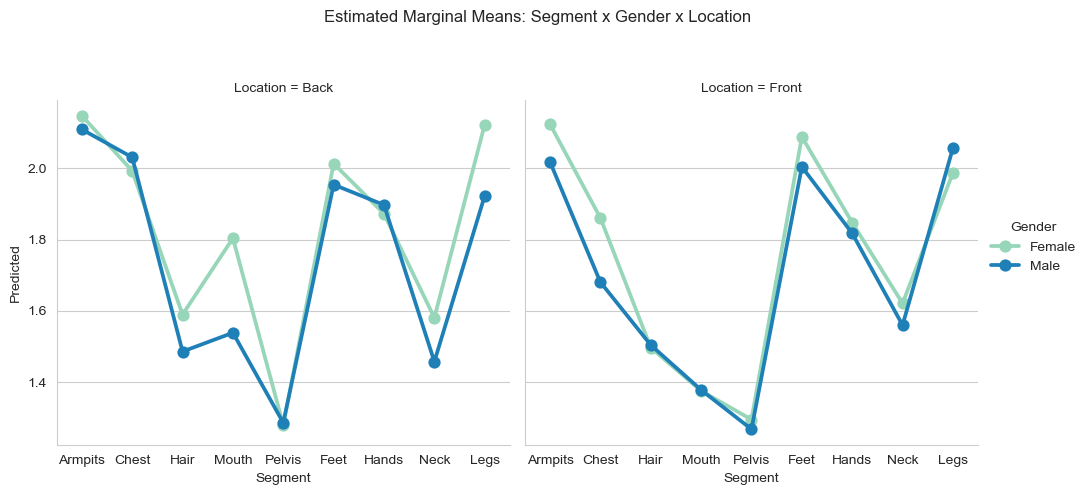

In [19]:
# Create a grid of all combinations
combinations = pd.DataFrame([
    (seg, gen, loc)
    for seg in target['Segment'].unique()
    for gen in target['Gender'].unique()
    for loc in target['Location'].unique()
], columns=['Segment', 'Gender', 'Location'])

# Predict marginal means
combinations['Predicted'] = three_model.predict(combinations)

# Plot 3-way interaction
sns.catplot(
    data=combinations,
    x='Segment',
    y='Predicted',
    hue='Gender',
    col='Location',
    kind='point',
    palette='YlGnBu',
    errorbar=None
)
plt.subplots_adjust(top=0.8)
plt.suptitle('Estimated Marginal Means: Segment x Gender x Location')
plt.show()

In [20]:
# target["Segment_Location"] = target["Segment"] + "_" + target["Location"]
# tukey = pairwise_tukeyhsd(target["Rating"], target["Segment_Location"])
# print(tukey)

In [30]:
# Take both Genders, front and back when smelling themselves
target = data[
    (data['Location'].isin(['Front', 'Back'])) &
    (data['Type'] == 'Self') &
    (data['Gender'].isin(['Female', 'Male']))
    ].copy()
# target['group1'] = (
#         target['Location'] + '_'
#         + target['Segment']
# )

# target['group2'] = (
#         target['Gender'] + '_'
#         + target['Segment']
# )
target['group3'] = (
        target['Gender'].astype(str) + '_'
        + target['Location'].astype(str) + '_'
        + target['Segment'].astype(str)
)

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group3'], alpha=0.05)
#
# # group     meandiff	p-adj	lower	upper	reject
# # (front vs back)
# # armpit	-0.0481	    0.9999	-0.2054	0.1093	False
# # chest	    -0.2054	    0.7353	-0.5271	0.1163	False
# # feet	    0.0671	    0.9986	-0.1164	0.2506	False
# # hair	    -0.0627	    1.0	    -0.3866	0.2612	False
# # hand	    -0.0428	    1.0	    -0.281	0.1954	False
# # knee	    -0.0394	    1.0	    -0.597	0.5182	False
# # mouth	    -0.3381	    0.1214	-0.7076	0.0314	False
# # neck	    0.0695	    1.0	    -0.224	0.3629	False
# # pelvis	0.0039	    1.0	    -0.1752	0.1831	False
# #
# # group     meandiff	p-adj	lower	upper	reject
# # (Female vs Male)
# # armpit	-0.084	    0.9009	-0.236	0.0679	False
# # chest	    -0.0897	    0.9999	-0.4026	0.2231	False
# # feet	    -0.075	    0.9957	-0.2619	0.1119	False
# # hair	    -0.0351	    1.0	    -0.3826	0.3125	False
# # hand	    -0.0119	    1.0	    -0.2541	0.2302	False
# # knee	    -0.0618	    1.0	    -0.6508	0.5272	False
# # mouth	    -0.0487	    1.0	    -0.3572	0.2598	False
# # neck	    -0.0892	    0.9999	-0.3832	0.2048	False
# # pelvis	    -0.0146	    1.0	    -0.1944	0.1652	False
# #
# # When comparing the same Locations, there is no statistically difference between Gender or Location regarding smelling themselves

C:\Users\silva\AppData\Local\anaconda3\envs\bodyOdors\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [22]:
# # Plot Tukey's HSD results
# tukey.plot_simultaneous(comparison_name=None, xlabel='Mean difference', ylabel='Groups')
# plt.title('Tukey HSD: Pairwise Group Comparisons')
# plt.show()

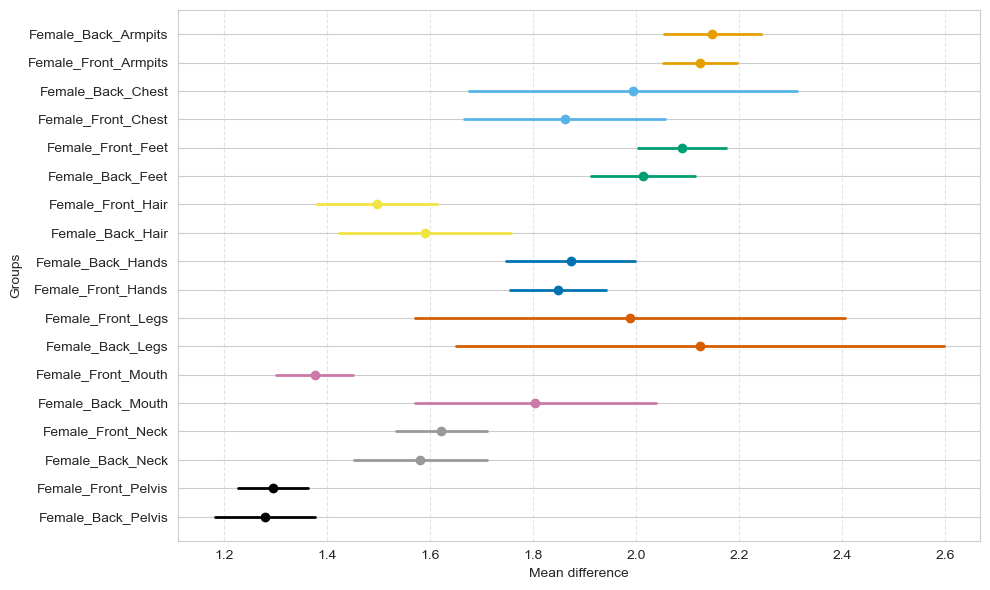

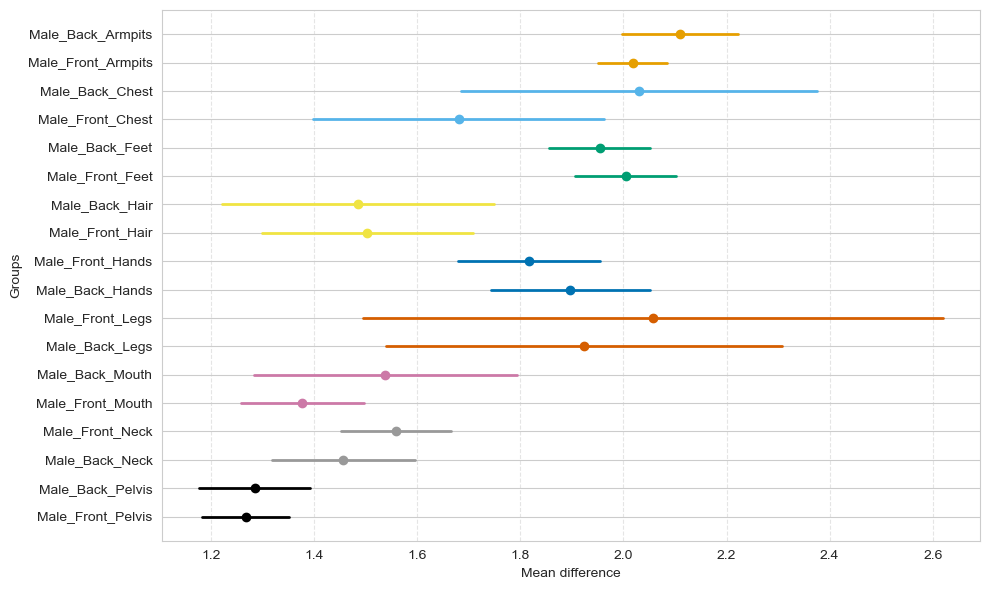

In [31]:
group = 'group3'
summary = (
    target.groupby(group)['Rating']
    .agg(['mean', 'count', 'std'])
    .reset_index()
)
summary = summary.sort_values('mean')

summary['ci95'] = 1.96 * (summary['std'] / summary['count'] ** 0.5)
summary['lower'] = summary['mean'] - summary['ci95']
summary['upper'] = summary['mean'] + summary['ci95']

colors = ['#E69F00',  # orange
          '#56B4E9',  # sky blue
          '#009E73',  # bluish green
          '#F0E442',  # yellow
          '#0072B2',  # blue
          '#D55E00',  # vermillion
          '#CC79A7',  # reddish purple
          '#999999',  # gray
          '#000000',  # black
          ]

# highlight_groups = [['Front_Armpits', 'Back_Armpits'],
#                     ['Front_Chest', 'Back_Chest'],
#                     ['Front_Feet', 'Back_Feet'],
#                     ['Front_Hair', 'Back_Hair'],
#                     ['Front_Hands', 'Back_Hands'],
#                     ['Front_Legs', 'Back_Legs'],
#                     ['Front_Mouth', 'Back_Mouth'],
#                     ['Front_Neck', 'Back_Neck'],
#                     ['Front_Pelvis', 'Back_Pelvis']]

highlight_groups = [['Armpits'],
                    ['Chest'],
                    ['Feet'],
                    ['Hair'],
                    ['Hands'],
                    ['Legs'],
                    ['Mouth'],
                    ['Neck'],
                    ['Pelvis']]

fem_sum = summary[summary[group].str.contains('Female')]
mal_sum = summary[summary[group].str.contains('Male')]

fem_sum['sort_key'] = fem_sum[group].apply(lambda x: x.split('_')[2] if '_' in x else x)
fem_sum = fem_sum.sort_values('sort_key')

group_color_map = {}
for group_pair, color in zip(highlight_groups, colors):
    for g in group_pair:
        group_color_map[g] = color

fem_sum['color'] = fem_sum["sort_key"].map(group_color_map).fillna('black')

fig, ax = plt.subplots(figsize=(10, 6))

for i, row in enumerate(fem_sum.itertuples()):
    ax.plot([row.lower, row.upper], [i, i], color=row.color, lw=2)
    ax.plot(row.mean, i, 'o', color=row.color)

ax.set_yticks(range(len(fem_sum)))
ax.set_yticklabels(fem_sum[group])
ax.invert_yaxis()
ax.set_xlabel('Mean difference')
ax.set_ylabel('Groups')
# ax.set_title('Tukey HSD: Pairwise Group Comparisons')

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('output/stats/Tukey-self-locations-fem.png', bbox_inches='tight', dpi=300)
plt.show()

mal_sum['sort_key'] = mal_sum[group].apply(lambda x: x.split('_')[2] if '_' in x else x)
mal_sum = mal_sum.sort_values('sort_key')

group_color_map = {}
for group_pair, color in zip(highlight_groups, colors):
    for g in group_pair:
        group_color_map[g] = color

mal_sum['color'] = mal_sum["sort_key"].map(group_color_map).fillna('black')

fig, ax = plt.subplots(figsize=(10, 6))

for i, row in enumerate(mal_sum.itertuples()):
    ax.plot([row.lower, row.upper], [i, i], color=row.color, lw=2)
    ax.plot(row.mean, i, 'o', color=row.color)

ax.set_yticks(range(len(mal_sum)))
ax.set_yticklabels(mal_sum[group])
ax.invert_yaxis()
ax.set_xlabel('Mean difference')
ax.set_ylabel('Groups')
# ax.set_title('Tukey HSD: Pairwise Group Comparisons')

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('output/stats/Tukey-self-locations-mal.png', bbox_inches='tight', dpi=300)

In [24]:
# # 3. is there any difference when Males smell themselves vs when they smell Others?
# target = (data[
#               (data['Type'].isin(['Self', 'Other'])) &
#               (data['Gender'] == 'Male')]
#           .copy())
# three_model = ols("""Rating ~ C(Segment) + C(Type) + C(Location) +
#                C(Segment):C(Type) + C(Segment):C(Location) + C(Type):C(Location) +
#                C(Segment):C(Type):C(Location)""", data=target).fit()
# res3 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Type) -> p= 0,031
# C(Location) -> p= 0,043
# C(Segment):C(Type) -> p= 0,537
# C(Segment):C(Location) -> p= 0,001
# C(Type):C(Location) -> p= 0,884
# C(Segment):C(Type):C(Location) -> p= 0,984

# Answer, there is a main effect of Type, and there is significant difference
# between Segment and Location when participants smell themselves vs when they smell Others

In [25]:
# # Lets check the above
# target = data[
#     (data['Location'].isin(['Front', 'Back'])) &
#     (data['Gender'] == 'Male') &
#     (data['Type'].isin(['Self', 'Other']))
#     ].copy()
# target['group1'] = (
#         target['Type'] + '_'
#         + target['Segment']
# )
# target['group2'] = (
#         target['Location'] + '_'
#         + target['Segment']
# )
# tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group2'], alpha=0.05)

# group     meandiff	p-adj	lower	upper	reject
# (Self vs Other)
# armpit	-0.0506	    0.9999	-0.217	0.1158	False
# chest	    -0.0745	    1.0	    -0.39	0.2411	False
# feet	    -0.0883	    0.9916	-0.2955	0.1188	False
# hair	    0.0869	    1.0	    -0.2664	0.4402	False
# hand	    0.0305	    1.0	    -0.2601	0.321	False
# knee	    0.1451	    1.0	    -0.4341	0.7243	False
# mouth	    -0.127	    0.997	-0.4533	0.1994	False
# neck	    -0.0494	    1.0	    -0.3232	0.2244	False
# pelvis	-0.1268	    0.7585	-0.3285	0.0749	False

# group     meandiff	p-adj	lower	upper	reject
# (front vs back)
# armpit	-0.1062	    0.8087	-0.2815	0.0691	False
# chest	    -0.3709	    0.0032	-0.6774	-0.0643	True
# feet	    0.0838	    0.9961	-0.1266	0.2942	False
# hair	    -0.1236	    0.999	-0.4705	0.2233	False
# hand	    -0.0699	    1.0	    -0.3747	0.2348	False
# knee	    -0.0048	    1.0	    -0.5552	0.5456	False
# mouth	    -0.1502	    0.9962	-0.5281	0.2277	False
# neck	    0.11	    0.9898	-0.1436	0.3636	False
# pelvis	-0.0228	    1.0	    -0.2266	0.1811	False

In [26]:
# summary = (
#     target.groupby('group2')['Rating']
#     .agg(['mean', 'count', 'std'])
#     .reset_index()
# )
# summary = summary.sort_values('mean')
#
# summary['ci95'] = 1.96 * (summary['std'] / summary['count'] ** 0.5)
# summary['lower'] = summary['mean'] - summary['ci95']
# summary['upper'] = summary['mean'] + summary['ci95']
#
# colors = ['#E69F00',  # orange
#           '#56B4E9',  # sky blue
#           '#009E73',  # bluish green
#           '#F0E442',  # yellow
#           '#0072B2',  # blue
#           '#D55E00',  # vermillion
#           '#CC79A7',  # reddish purple
#           '#999999',  # gray
#           '#000000',  # black
#           ]
#
# highlight_groups = [['Front_Armpits', 'Back_Armpits'],
#                     ['Front_Chest', 'Back_Chest'],
#                     ['Front_Feet', 'Back_Feet'],
#                     ['Front_Hair', 'Back_Hair'],
#                     ['Front_Hands', 'Back_Hands'],
#                     ['Front_Legs', 'Back_Legs'],
#                     ['Front_Mouth', 'Back_Mouth'],
#                     ['Front_Neck', 'Back_Neck'],
#                     ['Front_Pelvis', 'Back_Pelvis']]
#
# summary['sort_key'] = summary['group2'].apply(lambda x: x.split('_')[1] if '_' in x else x)
#
# # Sort rows by that substring
# summary = summary.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)
#
# group_color_map = {}
# for group_pair, color in zip(highlight_groups, colors):
#     for g in group_pair:
#         group_color_map[g] = color
#
# summary['color'] = summary['group2'].map(group_color_map).fillna('black')
#
# fig, ax = plt.subplots(figsize=(10, 6))
#
# for i, row in enumerate(summary.itertuples()):
#     ax.plot([row.lower, row.upper], [i, i], color=row.color, lw=2)
#     ax.plot(row.mean, i, 'o', color=row.color)
#
# ax.set_yticks(range(len(summary)))
# ax.set_yticklabels(summary['group2'])
# ax.invert_yaxis()
# ax.set_xlabel('Mean difference')
# ax.set_ylabel('Groups')
# ax.set_title('Tukey HSD: Pairwise Group Comparisons')
#
# plt.grid(True, axis='x', linestyle='--', alpha=0.5)
# plt.tight_layout()
# # plt.savefig('output/stats/Tukey-self-locations.png', bbox_inches='tight', dpi=300)

In [27]:
# # 4. is there any difference when Females smell themselves vs when they smell Others?
# target = (data[
#               (data['Type'].isin(['Self', 'Other'])) &
#               (data['Gender'] == 'Female')]
#           .copy())
# three_model = ols("""Rating ~ C(Segment) + C(Type) + C(Location) +
#                C(Segment):C(Type) + C(Segment):C(Location) + C(Type):C(Location) +
#                C(Segment):C(Type):C(Location)""", data=target).fit()
# res4 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Type) -> p= 0,955
# C(Location) -> p= 0,569
# C(Segment):C(Type) -> p= 0,043
# C(Segment):C(Location) -> p= 7,251
# C(Type):C(Location) -> p= 0,478
# C(Segment):C(Type):C(Location) -> p= 0,881

In [29]:
## Lets check the above
target = data[
    (data['Location'].isin(['Front', 'Back'])) &
    (data['Gender'] == 'Female') &
    (data['Type'].isin(['Self', 'Other']))
    ].copy()

target['group'] = target['Type'] + '_' + target['Segment']

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group'], alpha=0.05)
#
# # group     meandiff	p-adj	lower	upper	reject
# # (Self vs Other)
# # armpit	0.0552	0.9952	-0.0808	0.1912	False
# # chest	    0.0606	1.0	    -0.1973	0.3184	False
# # feet	    -0.1047	0.7349	-0.2687	0.0593	False
# # hair	    0.0679	1.0	    -0.1833	0.3191	False
# # hand	    -0.0807	0.9985	-0.3	0.1385	False
# # knee	    0.2483	0.9338	-0.2234	0.72	False
# # mouth	    -0.3381	0.1214	-0.7076	0.0314	False
# # pelvis	0.0039	1.0	    -0.1752	0.1831	False
# # neck 	    0.0695	1.0	    -0.224	0.3629	False
# # mouth	    -0.0743	0.9999	-0.3243	0.1756	False
# # neck 	    0.0341	1.0	    -0.1943	0.2625	False
# # pelvis	-0.0141	1.0	    -0.1776	0.1494	False
# #
# # None

TypeError: unsupported operand type(s) for +: 'Categorical' and 'str'

In [28]:
# 5. Comparing the body as whole, is there any difference between Female and Males when smelling themselves in front and back, and what about when smelling Others?
target = (data[
              (data['Type'].isin(['Self', 'Other'])) &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
three_model = ols("""Rating ~ C(Gender) + C(Type) + C(Location) +
               C(Gender):C(Type) + C(Gender):C(Location) + C(Type):C(Location) +
               C(Gender):C(Type):C(Location)""", data=target).fit()
res5 = anova_lm(three_model, typ=2)
# None


In [27]:
# 6. Where do Females prefer to smell themselves (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Female') &
    (data['Type'] == 'Self')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Armpits  Chest  -0.2632 0.0102 -0.4908 -0.0356   True
Armpits   Feet  -0.0353 0.9993 -0.2045  0.1338  False
Armpits   Hair  -0.6272    0.0 -0.8713 -0.3832   True
Armpits  Hands  -0.2763 0.0003 -0.4674 -0.0851   True
Armpits   Legs  -0.1364 0.9894 -0.5782  0.3054  False
Armpits  Mouth  -0.7486    0.0  -0.961 -0.5363   True
Armpits   Neck  -0.5029    0.0 -0.7347 -0.2711   True
Armpits Pelvis  -0.8291    0.0 -0.9906 -0.6677   True
  Chest   Feet   0.2279 0.0864 -0.0151  0.4708  False
  Chest   Hair   -0.364 0.0053  -0.664 -0.0641   True
  Chest  Hands  -0.0131    1.0 -0.2719  0.2457  False
  Chest   Legs   0.1268  0.996 -0.3482  0.6018  False
  Chest  Mouth  -0.4854    0.0 -0.7602 -0.2106   True
  Chest   Neck  -0.2397  0.202 -0.5298  0.0503  False
  Chest Pelvis  -0.5659    0.0 -0.8036 -0.3283   True
   Feet   Hair  -0.5919    0

In [26]:
# 7. Where do Females prefer to smell Others (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Female') &
    (data['Type'] == 'Other')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Armpits  Chest  -0.2475 0.0372 -0.4875 -0.0075   True
Armpits   Feet   0.1759  0.033  0.0074  0.3443   True
Armpits   Hair  -0.5949    0.0 -0.8036 -0.3862   True
Armpits  Hands  -0.1567 0.3168 -0.3643  0.0509  False
Armpits   Legs  -0.3663 0.1799 -0.8007  0.0681  False
Armpits  Mouth  -0.6053    0.0 -0.8038 -0.4067   True
Armpits   Neck  -0.4176    0.0 -0.6002 -0.2349   True
Armpits Pelvis  -0.6881    0.0  -0.863 -0.5132   True
  Chest   Feet   0.4234    0.0  0.1706  0.6761   True
  Chest   Hair  -0.3474 0.0041 -0.6285 -0.0662   True
  Chest  Hands   0.0908 0.9855 -0.1895  0.3711  False
  Chest   Legs  -0.1188 0.9974 -0.5923  0.3547  False
  Chest  Mouth  -0.3578 0.0017 -0.6315 -0.0841   True
  Chest   Neck  -0.1701 0.5354 -0.4324  0.0923  False
  Chest Pelvis  -0.4406    0.0 -0.6976 -0.1835   True
   Feet   Hair  -0.7707    0

In [25]:
# 8. Where do Males prefer to smell themselves (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Male') &
    (data['Type'] == 'Self')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Armpits  Chest  -0.3373 0.0078 -0.6232 -0.0515   True
Armpits   Feet  -0.0134    1.0 -0.2122  0.1853  False
Armpits   Hair  -0.5139    0.0 -0.8363 -0.1914   True
Armpits  Hands  -0.2003 0.1603 -0.4334  0.0329  False
Armpits   Legs   0.0393    1.0 -0.5431  0.6218  False
Armpits  Mouth  -0.6399    0.0 -0.8985 -0.3814   True
Armpits   Neck   -0.458    0.0 -0.7342 -0.1819   True
Armpits Pelvis  -0.7502    0.0 -0.9434  -0.557   True
  Chest   Feet   0.3239 0.0264  0.0201  0.6278   True
  Chest   Hair  -0.1765 0.9041 -0.5725  0.2194  False
  Chest  Hands   0.1371 0.9316 -0.1903  0.4644  False
  Chest   Legs   0.3767 0.6365 -0.2495  1.0028  False
  Chest  Mouth  -0.3026 0.1427 -0.6485  0.0433  False
  Chest   Neck  -0.1207 0.9816 -0.4799  0.2385  False
  Chest Pelvis  -0.4129 0.0007 -0.7131 -0.1126   True
   Feet   Hair  -0.5005 0.00

In [24]:
# 8. Where do Females prefer to smell Others (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Male') &
    (data['Type'] == 'Other')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Armpits  Chest   -0.375 0.0008 -0.6492 -0.1009   True
Armpits   Feet   0.0658 0.9869 -0.1406  0.2722  False
Armpits   Hair  -0.7152    0.0 -0.9667 -0.4638   True
Armpits  Hands  -0.2624 0.0463 -0.5227 -0.0021   True
Armpits   Legs  -0.2628 0.6915 -0.7194  0.1939  False
Armpits  Mouth  -0.5545    0.0 -0.8031 -0.3059   True
Armpits   Neck  -0.4407    0.0 -0.6518 -0.2295   True
Armpits Pelvis  -0.6601    0.0 -0.8689 -0.4513   True
  Chest   Feet   0.4408 0.0001  0.1466  0.7351   True
  Chest   Hair  -0.3402 0.0346 -0.6677 -0.0127   True
  Chest  Hands   0.1126 0.9813 -0.2217  0.4469  False
  Chest   Legs   0.1123 0.9989 -0.3902  0.6148  False
  Chest  Mouth  -0.1795 0.7389 -0.5047  0.1458  False
  Chest   Neck  -0.0656  0.999 -0.3633   0.232  False
  Chest Pelvis  -0.2851 0.0695  -0.581  0.0109  False
   Feet   Hair   -0.781    0

In [34]:
# sns.stripplot(
#     data=female,
#     x='Segment',
#     y='Rating',
#     hue='Type',
#     # col_wrap=2,
#     # showfliers=False
# )
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.suptitle('Female: Percentage by Segment, Type, and Location')

In [35]:
# sns.stripplot(
#     data=Males,
#     x='Segment',
#     y='Rating',
#     hue='Type',
#     # col_wrap=2,
#     # showfliers=False
# )
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.suptitle('Female: Percentage by Segment, Type, and Location')

In [36]:
# summary_df = (
#     male.groupby(['Location', 'Type', 'Segment'])['Rating']
#     .mean()
#     .reset_index()
# )
#
# summary_df['sort_key'] = summary_df["Segment"].apply(lambda x: x.split('_')[1] if '_' in x else x)
# summary_df = summary_df.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)
#
# location = 'Front'
# pivot_df = summary_df[summary_df['Location'] == location].pivot(
#     index='Type',
#     columns='Segment',
#     values='Rating'
# )
# categories = list(pivot_df.columns)
# N = len(categories)
#
# angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
# angles += angles[:1]
#
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#
# # Plot each Type
# for idx, row in pivot_df.iterrows():
#     values = row.tolist()
#     values += values[:1]
#     ax.plot(angles, values, label=idx)
#     ax.fill(angles, values, alpha=0.1)
#
# ticks = [0.5, 1.0, 1.5, 2.0, 2.5]
#
# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(categories)
# ax.set_yticks(ticks)
# ax.set_title(f'Males Body Odor Ratings for Body Location: {location}')
# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.savefig('output/Radar-male-front.png', dpi=350, bbox_inches='tight')
# plt.show()